As it is difficult to test the accuracy of the algorithm in the Los Alamos dataset, we will create a artificial dataset for this purpose. A mixture of distributions will denote the possible states each host can be part of for each individual epoch. 

A set of different clusters of hosts will be created. Each set will have hosts, whose points are generated through the same transition matrices.

First we define the states that each data points can be part of. We will use a two dimensional space and a total of 7 total distributions.

In [1]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75], [30,40], [35,25]])
# set the weights of each distributions the same
weights = np.array([1/len(lambdas)] * len(lambdas))

# get random samples from these distributions
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

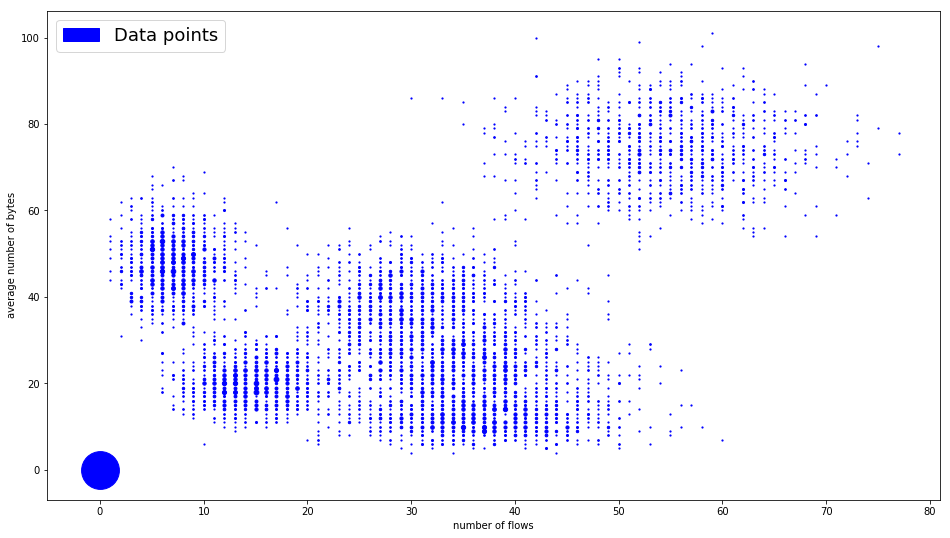

In [2]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see most of these cluster are clearly seperated. Some of them are not. This is done on purpose to simulate a real example. From the random samples generated above, we can found the probability that a random sample has the maximum mass function value, for the distribution it originated from.

Let K be the total number of the distributions.


Then for the $i^{th}$ sample drawn from the distribution k, the most likely distribution it originated from would be:

$$k_i = \underset{k}{\operatorname{argmax}} f(x_i, l_k)$$

where $$f(x, l_i) = \frac{(l_i)^x e^{-l_i}}{x!}$$

In [6]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

predictions = []
true_classes = []
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    predictions.append(classification)
    true_classes.append(point[2])

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['class ' + str(i) for i in range(len(lambdas))]
print('confusion_matrix: ')
print(confusion_matrix(true_classes, predictions))

print()
print()
print(classification_report(true_classes, predictions, target_names=target_names))

confusion_matrix: 
[[1000    0    0    0    0    0    0]
 [   0  963   13    3    0    6   15]
 [   0    2  939    0    0    0   59]
 [   0    1    0  998    0    1    0]
 [   0    0    0    0  998    2    0]
 [   0    8    0    3    0  913   76]
 [   0   16   61    0    0   71  852]]


             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      1000
    class 1       0.97      0.96      0.97      1000
    class 2       0.93      0.94      0.93      1000
    class 3       0.99      1.00      1.00      1000
    class 4       1.00      1.00      1.00      1000
    class 5       0.92      0.91      0.92      1000
    class 6       0.85      0.85      0.85      1000

avg / total       0.95      0.95      0.95      7000



Now we will create the clusters of the transition matrices.

We will create a number of clusters containing different number of hosts each to stimulate a real example.

The parameter L denotes the total number of these matrices clusters.

In [13]:
import random as ran

L = 9
num_hosts_per_L = [40, 45, 50, 55, 60, 70, 80, 100, 150]

def random_vector(size=7):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=7):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [14]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host.

Each host, for the first epoch, has a datapoints at a random distribution. The next datapoint will belong to a new distribution depending on a roulette wheel mechanism and the transition probabilities of the cluster the host belongs to.

In [15]:
data_points = []
number_of_epochs = 500

# creates a random data point for a specified distribution and adds it to the total data points
def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that initial EM mixtures center points, might have some differences to the desired final points, so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [18]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

Select some random data points as the initial ones.

In [25]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7


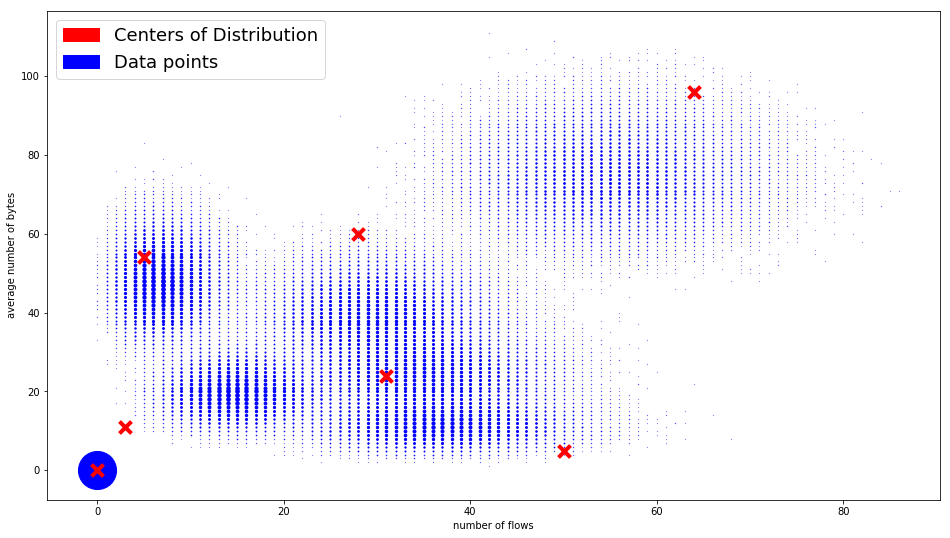

In [26]:
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)

# the initial data points
plot_points(data_points[:, :2], onlineEM)

In [27]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


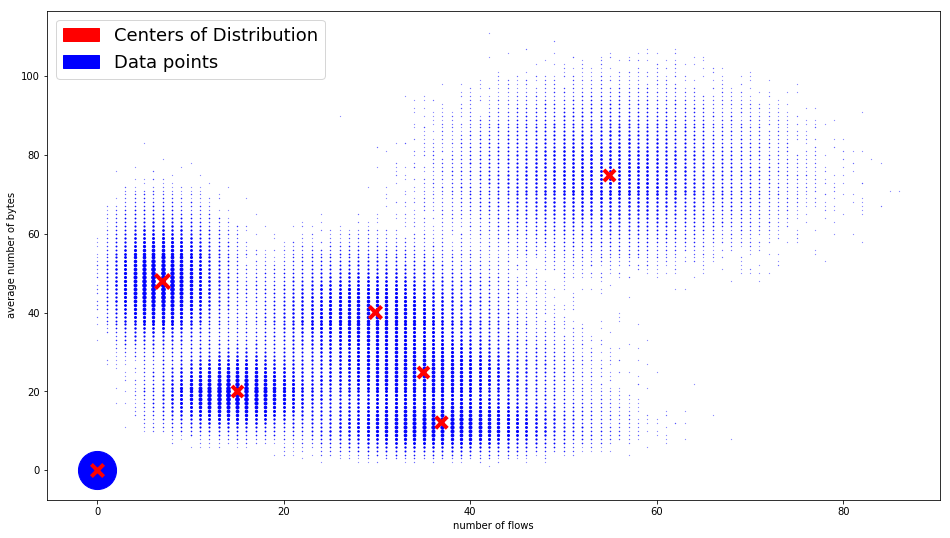

In [28]:
# the final data points
plot_points(data_points[:, :2], onlineEM)

In [63]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.18127675  0.16475451  0.10401049  0.12054723  0.14331179  0.15711916
  0.12898007]
[[29.984682893909323 40.103150891012113]
 [54.93841797622418 74.828638345120552]
 [0.0 0.0]
 [37.027641001681928 12.077522267021227]
 [7.0222886455974907 48.12644858919198]
 [34.900172998679324 24.953424346672822]
 [15.036863987939793 19.842709341783685]]


The transition matrices will be initialized to the following table (normalized to 1):

initializer:

|  |
| :-------------: |:-------------:| :-----:|
| 1  | 0.5 | ... | 0.5 | 
| 0.5  | 1 | ... | 0.5 | 
| ...  | ... | ... | .. | 
| 0.5  | 0.5 | ... | 1 | 


The final transition matrix will be:

$$\frac{initializer}{num\_points + 1} + \frac{transition\_matrix * num\_points}{num\_points + 1}$$ for each individual row.

This is done manually in the following cells but in the final version of the algorithm will be done automatically

In [65]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [66]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

Now we can cluster the transition matrices.

In [67]:
from klkmeans import kMenas

kmeans = kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 128.075588915
The cost is 72.5127198373
The cost is 72.4541023725
The cost is 72.4360611973
The cost is 72.4145752484
The cost is 72.4066606763
converged
Starting run
The cost is 138.984321828
The cost is 89.6400770845
The cost is 72.6790759066
converged
Starting run
The cost is 111.912004766
The cost is 74.7980874899
The cost is 56.5486010063
converged
Starting run
The cost is 136.20651923
The cost is 57.071250493
The cost is 56.5486010063
converged
Starting run
The cost is 170.482438489
The cost is 94.903060586
The cost is 56.5486010063
converged
Starting run
The cost is 170.665309145


c:\users\sotiris\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


The cost is 123.918341965
The cost is 99.3503569977
The cost is 99.2811452427
The cost is 99.2584046932
The cost is 99.2128209958
The cost is 99.1644753082
The cost is 99.1469113052
The cost is 99.1382103055
The cost is 99.1366604184
converged
Starting run
The cost is 165.956856132
The cost is 84.852053669
The cost is 76.7589470643
converged
Starting run
The cost is 132.962885344
The cost is 82.6552015579
The cost is 72.5983930641
converged
Starting run
The cost is 132.580484959
The cost is 56.5486010063
converged
Starting run
The cost is 122.990756772
The cost is 78.3864211187
The cost is 72.6985682343
converged


In [68]:
centroids = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
centroids

array([[  0,   0,   0,   0,   0,   0,   0,   0,  40],
       [ 45,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  50,   0,   0,   0],
       [  0,   0,   0,  55,   0,   0,   0,   0,   0],
       [  0,   0,  60,   0,   0,   0,   0,   0,   0],
       [  0,  70,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  80,   0,   0],
       [  0,   0,   0,   0, 100,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 150,   0]], dtype=int64)

The results in this case are the perfect desired ones. This might not always be the case.

The real number of original distributions and the number of hosts clusters will probably be unknown.

Furthermore, in some cases, some of the smaller cluster might be mistakenly joined with some of the largests. This should be expected if the original transition matrices are not devergent enough.